In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split
data_train = pd.read_csv("housing.csv")
data_test = pd.read_csv("housing.csv")

#删除不相关属性
X = data_train.drop('MEDV', axis=1)
Y = data_train.MEDV

#准备训练集和测试集
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.15,random_state=233)

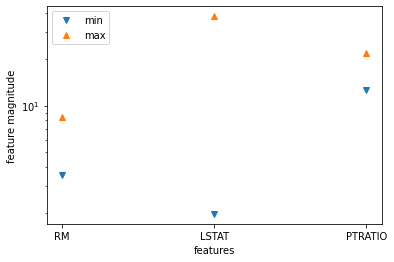

3.561 8.398
1.98 37.97
12.6 22.0


In [62]:
#特征数值中最小值和最大值数据可视化（防止不同数据特征量级差异较大）
import matplotlib.pyplot as plt
plt.plot(X.min(axis=0),'v',label='min')#axis=0表示列
plt.plot(X.max(axis=0),'^',label='max')
plt.yscale('log')
plt.legend(loc='best')
plt.xlabel('features')
plt.ylabel('feature magnitude')
plt.show()
print(X.RM.min(axis=0),X.RM.max(axis=0))
print(X.LSTAT.min(axis=0),X.LSTAT.max(axis=0))
print(X.PTRATIO.min(axis=0),X.PTRATIO.max(axis=0))

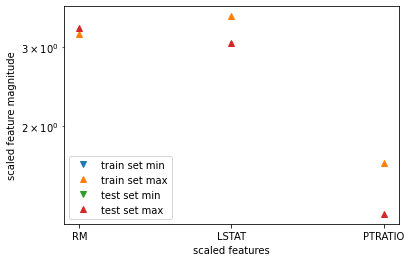

In [63]:
#数据预处理(减小数据量级差异)
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X_train)

cols = X_train.columns
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=cols)

plt.plot(X_train_scaled.min(axis=0),'v',label='train set min')
plt.plot(X_train_scaled.max(axis=0),'^',label='train set max')
plt.plot(X_test_scaled.min(axis=0),'v',label='test set min')
plt.plot(X_test_scaled.max(axis=0),'^',label='test set max')
plt.yscale('log')
plt.legend(loc='best')
plt.xlabel('scaled features')
plt.ylabel('scaled feature magnitude')
plt.show()

In [64]:
#使用预处理后的数据训练SVR模型
from sklearn.svm import SVR
from sklearn.svm import SVC
import numpy as np
from sklearn.metrics import mean_squared_error
for kernel in ['linear','rbf']:
    svr=SVR(kernel=kernel)
    svr.fit(X_train_scaled,Y_train)
    svr_pre=svr.predict(X_test)
    print(kernel,'核函数的模型训练集得分：{:.3f}'.format(svr.score(X_train_scaled,Y_train)))
    print(kernel,'核函数的模型测试集得分：{:.3f}'.format(svr.score(X_test_scaled,Y_test)))
    print('RMSE:{:.3f}'.format(np.sqrt(mean_squared_error(Y_test,svr_pre))))

linear 核函数的模型训练集得分：-0.001
linear 核函数的模型测试集得分：-0.001
RMSE:163143.635
rbf 核函数的模型训练集得分：-0.006
rbf 核函数的模型测试集得分：-0.006
RMSE:164336.856


In [65]:
#调整SVR模型的C参数和gramma参数
from sklearn import model_selection
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import numpy as np
param_grid={'kernel':('linear', 'rbf'), 'C':[1, 2, 4], 'gamma':[0.125, 0.25, 0.5 ,1, 2, 4]}
svr=model_selection.GridSearchCV(SVR(),param_grid)
svr.fit(X_train_scaled,Y_train)
svr_pre=svr.predict(X_test)
print('参数的最佳取值：{0}'.format(svr.best_params_))
print("调整参数后的模型在训练集得分：{:.3f}".format(svr.score(X_train_scaled,Y_train)))
print("调整参数后的模型在测试集得分：{:.3f}".format(svr.score(X_test_scaled,Y_test)))
print('RMSE:{:.3f}'.format(np.sqrt(mean_squared_error(Y_test,svr_pre))))

参数的最佳取值：{'C': 4, 'gamma': 0.125, 'kernel': 'linear'}
调整参数后的模型在训练集得分：0.014
调整参数后的模型在测试集得分：0.015
RMSE:160793.453


In [66]:
#Y值标准化
Y_mean=np.mean(Y,axis=0)
Y_std=np.std(Y,axis=0)
Y_train_scaled=(Y_train-Y_mean)/Y_std
Y_test_scaled=(Y_test-Y_mean)/Y_std
def get_originY(Y):
    return Y*Y_std+Y_mean

In [236]:
#再次尝试训练SVR模型
from sklearn import model_selection
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import numpy as np
param_grid={'kernel':('linear', 'rbf'), 'C':range(1,7), 
            'gamma':[0.01,0.05,0.1,0.125, 0.25, 0.5 ,1, 2, 4]}
svr=model_selection.GridSearchCV(SVR(),param_grid)
svr.fit(X_train_scaled,Y_train_scaled)
svr_pre=get_originY(svr.predict(X_test_scaled))
print('参数的最佳取值：{0}'.format(svr.best_params_))
print("调整参数后的模型在训练集得分：{:.3f}".format(svr.score(X_train_scaled,Y_train_scaled)))
print("调整参数后的模型在测试集得分：{:.3f}".format(svr.score(X_test_scaled,Y_test_scaled)))
print('RMSE:{:.3f}'.format(np.sqrt(mean_squared_error(Y_test,svr_pre))))

参数的最佳取值：{'C': 2, 'gamma': 0.25, 'kernel': 'rbf'}
调整参数后的模型在训练集得分：0.859
调整参数后的模型在测试集得分：0.876
RMSE:57587.635


In [104]:
#xgboost模型
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [107]:
#调n_estimators
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
cv_params = {'n_estimators': [25,50,75,100,200,300,400, 500]}
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 
                'min_child_weight': 1,'seed': 0,'subsample': 0.8, 'colsample_bytree': 0.8,
                'gamma': 0, 'reg_alpha': 0,'reg_lambda': 1}
model=xgb.XGBRegressor(**other_params)
optimized_GBM=GridSearchCV(estimator=model,param_grid=cv_params,scoring='r2',cv=5,
                           verbose=1,n_jobs=4)
optimized_GBM.fit(X_train_scaled, Y_train_scaled)
gbm_pre=get_originY(optimized_GBM.predict(X_test_scaled))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('模型训练集得分：{:.3f}'.format(optimized_GBM.score(X_train_scaled,Y_train_scaled)))
print('模型测试集得分：{:.3f}'.format(optimized_GBM.score(X_test_scaled,Y_test_scaled)))
print('RMSE:{:.3f}'.format(np.sqrt(mean_squared_error(Y_test,gbm_pre))))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
参数的最佳取值：{'n_estimators': 50}
模型训练集得分：0.945
模型测试集得分：0.857
RMSE:61852.891


In [155]:
#调mid_child_weight和max_depth
cv_params = {'max_depth': [2, 3, 4, 5, 6, 7, 8], 'min_child_weight': [1, 2, 3, 4, 5, 6]}
other_params = {'learning_rate': 0.1, 'n_estimators': 50, 'max_depth': 5, 'min_child_weight': 1,
                'seed': 0,'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0,
                'reg_lambda': 1}
model=xgb.XGBRegressor(**other_params)
optimized_GBM=GridSearchCV(estimator=model,param_grid=cv_params,scoring='r2',cv=5,verbose=1,n_jobs=4)
optimized_GBM.fit(X_train_scaled, Y_train_scaled)
gbm_pre=get_originY(optimized_GBM.predict(X_test_scaled))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('模型训练集得分：{:.3f}'.format(optimized_GBM.score(X_train_scaled,Y_train_scaled)))
print('模型测试集得分：{:.3f}'.format(optimized_GBM.score(X_test_scaled,Y_test_scaled)))
print('RMSE:{:.3f}'.format(np.sqrt(mean_squared_error(Y_test,gbm_pre))))

Fitting 5 folds for each of 42 candidates, totalling 210 fits
参数的最佳取值：{'max_depth': 3, 'min_child_weight': 1}
模型训练集得分：0.896
模型测试集得分：0.866
RMSE:59953.372


In [158]:
#调gamma
cv_params = {'gamma': [0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6]}
other_params = {'learning_rate': 0.1, 'n_estimators': 50, 'max_depth': 3, 'min_child_weight': 1,
                'seed': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0,
                'reg_lambda': 1}
model=xgb.XGBRegressor(**other_params)
optimized_GBM=GridSearchCV(estimator=model,param_grid=cv_params,scoring='r2',cv=5,verbose=1,n_jobs=4)
optimized_GBM.fit(X_train_scaled, Y_train_scaled)
gbm_pre=get_originY(optimized_GBM.predict(X_test_scaled))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('模型训练集得分：{:.3f}'.format(optimized_GBM.score(X_train_scaled,Y_train_scaled)))
print('模型测试集得分：{:.3f}'.format(optimized_GBM.score(X_test_scaled,Y_test_scaled)))
print('RMSE:{:.3f}'.format(np.sqrt(mean_squared_error(Y_test,gbm_pre))))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
参数的最佳取值：{'gamma': 0.3}
模型训练集得分：0.893
模型测试集得分：0.865
RMSE:60103.107


In [114]:
#调subsample和colsample_bytree
cv_params = {'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]}
other_params = {'learning_rate': 0.1, 'n_estimators': 50, 'max_depth': 3, 'min_child_weight': 1,
                'seed': 0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.3, 'reg_alpha': 0,
                'reg_lambda': 1}
model=xgb.XGBRegressor(**other_params)
optimized_GBM=GridSearchCV(estimator=model,param_grid=cv_params,scoring='r2',cv=5,verbose=1,n_jobs=4)
optimized_GBM.fit(X_train_scaled, Y_train_scaled)
gbm_pre=get_originY(optimized_GBM.predict(X_test_scaled))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('模型训练集得分：{:.3f}'.format(optimized_GBM.score(X_train_scaled,Y_train_scaled)))
print('模型测试集得分：{:.3f}'.format(optimized_GBM.score(X_test_scaled,Y_test_scaled)))
print('RMSE:{:.3f}'.format(np.sqrt(mean_squared_error(Y_test,gbm_pre))))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
参数的最佳取值：{'colsample_bytree': 0.7, 'subsample': 0.8}
模型训练集得分：0.893
模型测试集得分：0.865
RMSE:60103.107


In [119]:
#调reg_alpha和reg_lambda
cv_params = {'reg_alpha': [0,0.05, 0.1, 1, 2, 3], 'reg_lambda': [0,0.05, 0.1, 1, 2, 3]}
other_params = {'learning_rate': 0.1, 'n_estimators': 50, 'max_depth': 3, 'min_child_weight': 1,
                'seed': 0,'subsample': 0.8, 'colsample_bytree': 0.7, 'gamma': 0.3, 'reg_alpha': 0, 
                'reg_lambda': 1}
model=xgb.XGBRegressor(**other_params)
optimized_GBM=GridSearchCV(estimator=model,param_grid=cv_params,scoring='r2',cv=5,verbose=1,n_jobs=4)
optimized_GBM.fit(X_train_scaled, Y_train_scaled)
gbm_pre=get_originY(optimized_GBM.predict(X_test_scaled))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('模型训练集得分：{:.3f}'.format(optimized_GBM.score(X_train_scaled,Y_train_scaled)))
print('模型测试集得分：{:.3f}'.format(optimized_GBM.score(X_test_scaled,Y_test_scaled)))
print('RMSE:{:.3f}'.format(np.sqrt(mean_squared_error(Y_test,gbm_pre))))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
参数的最佳取值：{'reg_alpha': 0.1, 'reg_lambda': 1}
模型训练集得分：0.888
模型测试集得分：0.864
RMSE:60334.724


In [117]:
#调learning_rate
cv_params = {'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.2]}
other_params = {'learning_rate': 0.1, 'n_estimators': 50, 'max_depth': 3, 'min_child_weight': 1,
                'seed': 0, 'subsample': 0.8, 'colsample_bytree': 0.7, 'gamma': 0.3, 'reg_alpha': 0.1, 
                'reg_lambda':1}
model=xgb.XGBRegressor(**other_params)
optimized_GBM=GridSearchCV(estimator=model,param_grid=cv_params,scoring='r2',cv=5,verbose=1,n_jobs=4)
optimized_GBM.fit(X_train_scaled, Y_train_scaled)
gbm_pre=get_originY(optimized_GBM.predict(X_test_scaled))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('模型训练集得分：{:.3f}'.format(optimized_GBM.score(X_train_scaled,Y_train_scaled)))
print('模型测试集得分：{:.3f}'.format(optimized_GBM.score(X_test_scaled,Y_test_scaled)))
print('RMSE:{:.3f}'.format(np.sqrt(mean_squared_error(Y_test,gbm_pre))))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
参数的最佳取值：{'learning_rate': 0.1}
模型训练集得分：0.888
模型测试集得分：0.864
RMSE:60334.724


In [159]:
#应用效果最好的参数组合进行训练
xg_reg = xgb.XGBRegressor(learning_rate=0.1, n_estimators=50, max_depth=3, min_child_weight=1, seed=0,subsample=0.8, colsample_bytree=0.8, gamma=0, reg_alpha=0, reg_lambda=1)
#xg_reg = xgb.XGBRegressor()
xg_reg.fit(X_train_scaled, Y_train_scaled)
xg_pre=get_originY(xg_reg.predict(X_test_scaled))
print('模型训练集得分：{:.3f}'.format(xg_reg.score(X_train_scaled,Y_train_scaled)))
print('模型测试集得分：{:.3f}'.format(xg_reg.score(X_test_scaled,Y_test_scaled)))
print('RMSE:{:.3f}'.format(np.sqrt(mean_squared_error(Y_test,xg_pre))))

模型训练集得分：0.896
模型测试集得分：0.866
RMSE:59953.372


In [120]:
#开一把线性回归模型
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_scaled, Y_train_scaled)
lr_pre=get_originY(lr.predict(X_test_scaled))
print('模型训练集得分：{:.3f}'.format(lr.score(X_train_scaled,Y_train_scaled)))
print('模型测试集得分：{:.3f}'.format(lr.score(X_test_scaled,Y_test_scaled)))
print('RMSE:{:.3f}'.format(np.sqrt(mean_squared_error(Y_test,lr_pre))))

模型训练集得分：0.711
模型测试集得分：0.753
RMSE:81379.523


In [125]:
#决策树回归
from sklearn.tree import DecisionTreeRegressor
cv_params = {'max_features': ['sqrt', 'log2', None],'max_depth': range(2,100)}
model = DecisionTreeRegressor()
tr=GridSearchCV(estimator=model,param_grid=cv_params,scoring='r2',cv=5,verbose=1,n_jobs=4)
tr.fit(X_train_scaled, Y_train_scaled) 
tr_pre=get_originY(tr.predict(X_test_scaled))
print('参数的最佳取值：{0}'.format(tr.best_params_))
print('模型训练集得分：{:.3f}'.format(tr.score(X_train_scaled,Y_train_scaled)))
print('模型测试集得分：{:.3f}'.format(tr.score(X_test_scaled,Y_test_scaled)))
print('RMSE:{:.3f}'.format(np.sqrt(mean_squared_error(Y_test,tr_pre))))

Fitting 5 folds for each of 294 candidates, totalling 1470 fits
参数的最佳取值：{'max_depth': 4, 'max_features': None}
模型训练集得分：0.868
模型测试集得分：0.708
RMSE:88570.145


In [128]:
#梯度提升
#调n_estimators
from sklearn import ensemble
cv_params = {'n_estimators':range(20,81,10)}
other_params = {}
model=ensemble.GradientBoostingRegressor(**other_params)
gb=GridSearchCV(estimator=model,param_grid=cv_params,scoring='r2',cv=5,verbose=1,n_jobs=4)
gb.fit(X_train_scaled, Y_train_scaled)
gb_pre=get_originY(gb.predict(X_test_scaled))
print('参数的最佳取值：{0}'.format(gb.best_params_))
print('模型训练集得分：{:.3f}'.format(gb.score(X_train_scaled,Y_train_scaled)))
print('模型测试集得分：{:.3f}'.format(gb.score(X_test_scaled,Y_test_scaled)))
print('RMSE:{:.3f}'.format(np.sqrt(mean_squared_error(Y_test,gb_pre))))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
参数的最佳取值：{'n_estimators': 50}
模型训练集得分：0.908
模型测试集得分：0.865
RMSE:60234.609


In [129]:
#调max_depth和min_samples_split
from sklearn import ensemble
cv_params = {'max_depth':range(3,14,2), 'min_samples_split':range(2,100)}
other_params = {'n_estimators':50}
model=ensemble.GradientBoostingRegressor(**other_params)
gb=GridSearchCV(estimator=model,param_grid=cv_params,scoring='r2',cv=5,verbose=1,n_jobs=4)
gb.fit(X_train_scaled, Y_train_scaled)
gb_pre=get_originY(gb.predict(X_test_scaled))
print('参数的最佳取值：{0}'.format(gb.best_params_))
print('模型训练集得分：{:.3f}'.format(gb.score(X_train_scaled,Y_train_scaled)))
print('模型测试集得分：{:.3f}'.format(gb.score(X_test_scaled,Y_test_scaled)))
print('RMSE:{:.3f}'.format(np.sqrt(mean_squared_error(Y_test,gb_pre))))

Fitting 5 folds for each of 588 candidates, totalling 2940 fits
参数的最佳取值：{'max_depth': 3, 'min_samples_split': 40}
模型训练集得分：0.901
模型测试集得分：0.866
RMSE:60001.837


In [131]:
#调min_samples_split和min_samples_leaf
from sklearn import ensemble
cv_params = {'min_samples_split':range(2,100), 'min_samples_leaf':range(1,10)}
other_params = {'n_estimators':50,'max_depth':3,'min_samples_split':40}
model=ensemble.GradientBoostingRegressor(**other_params)
gb=GridSearchCV(estimator=model,param_grid=cv_params,scoring='r2',cv=5,verbose=1,n_jobs=4)
gb.fit(X_train_scaled, Y_train_scaled)
gb_pre=get_originY(gb.predict(X_test_scaled))
print('参数的最佳取值：{0}'.format(gb.best_params_))
print('模型训练集得分：{:.3f}'.format(gb.score(X_train_scaled,Y_train_scaled)))
print('模型测试集得分：{:.3f}'.format(gb.score(X_test_scaled,Y_test_scaled)))
print('RMSE:{:.3f}'.format(np.sqrt(mean_squared_error(Y_test,gb_pre))))

Fitting 5 folds for each of 882 candidates, totalling 4410 fits
参数的最佳取值：{'min_samples_leaf': 6, 'min_samples_split': 30}
模型训练集得分：0.897
模型测试集得分：0.867
RMSE:59628.110


In [132]:
#用最优参数看看成效
from sklearn import ensemble
gb=ensemble.GradientBoostingRegressor(n_estimators=60,max_depth=3,min_samples_split=30,
                                     min_samples_leaf=6)
gb.fit(X_train_scaled, Y_train_scaled)
gb_pre=get_originY(gb.predict(X_test_scaled))
print('模型训练集得分：{:.3f}'.format(gb.score(X_train_scaled,Y_train_scaled)))
print('模型测试集得分：{:.3f}'.format(gb.score(X_test_scaled,Y_test_scaled)))
print('RMSE:{:.3f}'.format(np.sqrt(mean_squared_error(Y_test,gb_pre))))

模型训练集得分：0.901
模型测试集得分：0.868
RMSE:59438.213


In [135]:
#Lasso回归
from sklearn.linear_model import Lasso
lo = Lasso()
lo.fit(X_train_scaled, Y_train_scaled)
lo_pre=get_originY(lo.predict(X_test_scaled))
print('模型训练集得分：{:.3f}'.format(lo.score(X_train_scaled,Y_train_scaled)))
print('模型测试集得分：{:.3f}'.format(lo.score(X_test_scaled,Y_test_scaled)))
print('RMSE:{:.3f}'.format(np.sqrt(mean_squared_error(Y_test,lo_pre))))

模型训练集得分：0.000
模型测试集得分：-0.000
RMSE:163806.466


In [160]:
#Lasso回归
from sklearn.linear_model import Lasso
lo = Lasso()
lo.fit(X_train_scaled, Y_train)
lo_pre=lo.predict(X_test_scaled)
print('模型训练集得分：{:.3f}'.format(lo.score(X_train_scaled,Y_train)))
print('模型测试集得分：{:.3f}'.format(lo.score(X_test_scaled,Y_test)))
print('RMSE:{:.3f}'.format(np.sqrt(mean_squared_error(Y_test,lo_pre))))

模型训练集得分：0.711
模型测试集得分：0.753
RMSE:81379.359


In [137]:
#K近邻回归
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()
cv_params = {'weights': ['uniform', 'distance'],'n_neighbors': range(2,100)}
kn=GridSearchCV(estimator=model,param_grid=cv_params,scoring='r2',cv=5,verbose=1,n_jobs=4)
kn.fit(X_train_scaled, Y_train_scaled)
kn_pre=get_originY(kn.predict(X_test_scaled))
print('参数的最佳取值：{0}'.format(kn.best_params_))
print('模型训练集得分：{:.3f}'.format(kn.score(X_train_scaled,Y_train_scaled)))
print('模型测试集得分：{:.3f}'.format(kn.score(X_test_scaled,Y_test_scaled)))
print('RMSE:{:.3f}'.format(np.sqrt(mean_squared_error(Y_test,kn_pre))))

Fitting 5 folds for each of 196 candidates, totalling 980 fits
参数的最佳取值：{'n_neighbors': 9, 'weights': 'distance'}
模型训练集得分：1.000
模型测试集得分：0.858
RMSE:61630.630


In [139]:
#随机森林
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
cv_params = {'min_samples_split':range(5,20),'n_estimators':range(1,20)}
rf=GridSearchCV(estimator=model,param_grid=cv_params,scoring='r2',cv=5,verbose=1,n_jobs=4)
rf.fit(X_train_scaled, Y_train_scaled)
rf_pre=get_originY(rf.predict(X_test_scaled))
print('参数的最佳取值：{0}'.format(rf.best_params_))
print('模型训练集得分：{:.3f}'.format(rf.score(X_train_scaled,Y_train_scaled)))
print('模型测试集得分：{:.3f}'.format(rf.score(X_test_scaled,Y_test_scaled)))
print('RMSE:{:.3f}'.format(np.sqrt(mean_squared_error(Y_test,rf_pre))))

Fitting 5 folds for each of 285 candidates, totalling 1425 fits
参数的最佳取值：{'min_samples_split': 9, 'n_estimators': 11}
模型训练集得分：0.931
模型测试集得分：0.860
RMSE:61376.666


In [148]:
#集成学习
from sklearn.ensemble import AdaBoostRegressor
model=AdaBoostRegressor()
cv_params = {'n_estimators': range(20,30), 'learning_rate' : [0.01,0.05,0.1,0.15,0.2,0.25],'loss' : ['linear', 'square', 'exponential']}
abr=GridSearchCV(estimator=model,param_grid=cv_params,scoring='r2',cv=5,verbose=1,n_jobs=4)
abr.fit(X_train_scaled, Y_train_scaled)
abr_pre=get_originY(abr.predict(X_test_scaled))
print('参数的最佳取值：{0}'.format(abr.best_params_))
print('模型训练集得分：{:.3f}'.format(abr.score(X_train_scaled,Y_train_scaled)))
print('模型测试集得分：{:.3f}'.format(abr.score(X_test_scaled,Y_test_scaled)))
print('RMSE:{:.3f}'.format(np.sqrt(mean_squared_error(Y_test,abr_pre))))

Fitting 5 folds for each of 180 candidates, totalling 900 fits
参数的最佳取值：{'learning_rate': 0.2, 'loss': 'square', 'n_estimators': 23}
模型训练集得分：0.854
模型测试集得分：0.865
RMSE:60103.529


In [149]:
#弹性网络回归
from sklearn.linear_model import ElasticNet
en = ElasticNet()
en.fit(X_train_scaled, Y_train_scaled)
en_pre=get_originY(en.predict(X_test_scaled))
print('模型训练集得分：{:.3f}'.format(en.score(X_train_scaled,Y_train_scaled)))
print('模型测试集得分：{:.3f}'.format(en.score(X_test_scaled,Y_test_scaled)))
print('RMSE:{:.3f}'.format(np.sqrt(mean_squared_error(Y_test,en_pre))))

模型训练集得分：0.279
模型测试集得分：0.275
RMSE:139518.071


In [162]:
#弹性网络回归
from sklearn.linear_model import ElasticNet
en = ElasticNet()
en.fit(X_train, Y_train)
en_pre=en.predict(X_test)
print('模型训练集得分：{:.3f}'.format(en.score(X_train,Y_train)))
print('模型测试集得分：{:.3f}'.format(en.score(X_test,Y_test)))
print('RMSE:{:.3f}'.format(np.sqrt(mean_squared_error(Y_test,en_pre))))

模型训练集得分：0.683
模型测试集得分：0.706
RMSE:88783.038


In [227]:
#极端森林回归
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor()
cv_params = {'min_samples_split':range(5,15),'n_estimators':range(40,70)}
etc=GridSearchCV(estimator=model,param_grid=cv_params,scoring='r2',cv=5,verbose=1,n_jobs=4)
etc.fit(X_train_scaled, Y_train_scaled)
etc_pre=get_originY(etc.predict(X_test_scaled))
print('参数的最佳取值：{0}'.format(etc.best_params_))
print('模型训练集得分：{:.3f}'.format(etc.score(X_train_scaled,Y_train_scaled)))
print('模型测试集得分：{:.3f}'.format(etc.score(X_test_scaled,Y_test_scaled)))
print('RMSE:{:.3f}'.format(np.sqrt(mean_squared_error(Y_test,etc_pre))))

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
参数的最佳取值：{'min_samples_split': 11, 'n_estimators': 56}
模型训练集得分：0.918
模型测试集得分：0.868
RMSE:59579.637


In [194]:
#重复测试
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
R2=[]
RMSE=[]
MAE=[]
MAPE=[]
etc=ExtraTreesRegressor(min_samples_split=10,n_estimators=68)
for i in range(1000):
    etc.fit(X_train_scaled, Y_train_scaled)
    etc_pre=get_originY(etc.predict(X_test_scaled))
    R2.append(etc.score(X_test_scaled,Y_test_scaled))
    RMSE.append(np.sqrt(mean_squared_error(Y_test,etc_pre)))
    MAE.append(mean_absolute_error(Y_test, etc_pre))
    MAPE.append(mean_absolute_percentage_error(Y_test, etc_pre))

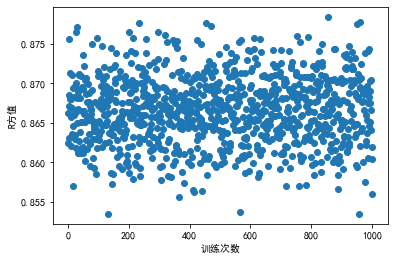

In [195]:
from pylab import *
mpl.rcParams["font.sans-serif"] = ["SimHei"]
import matplotlib.pyplot as plt
x=[i for i in range(1,1001)]
plt.scatter(x,R2)
plt.xlabel("训练次数")
plt.ylabel("R方值")
plt.show()

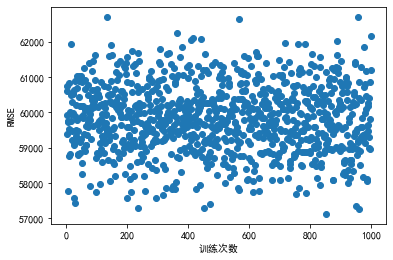

In [196]:
plt.scatter(x,RMSE)
plt.xlabel("训练次数")
plt.ylabel("RMSE")
plt.show()

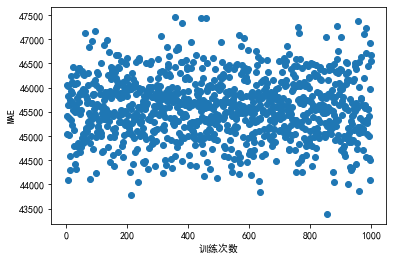

In [197]:
plt.scatter(x,MAE)
plt.xlabel("训练次数")
plt.ylabel("MAE")
plt.show()

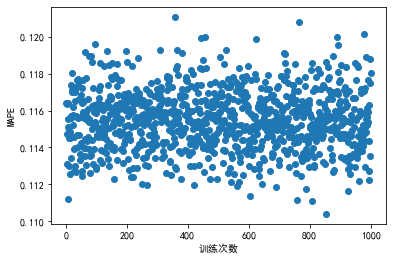

In [198]:
plt.scatter(x,MAPE)
plt.xlabel("训练次数")
plt.ylabel("MAPE")
plt.show()

In [298]:
#尝试融合模型
from sklearn.ensemble import VotingRegressor
r1 = SVR(C=3,gamma=0.1,kernel='rbf')
r2 = KNeighborsRegressor(n_neighbors=21,weights='distance')
r3 = ExtraTreesRegressor(min_samples_split=9,n_estimators=50)
com = VotingRegressor([('lr', r1), ('r3', r3)])
com.fit(X_train_scaled,Y_train_scaled)
com_pre=get_originY(com.predict(X_test_scaled))
print("调整参数后的模型在训练集得分：{:.3f}".format(com.score(X_train_scaled,Y_train_scaled)))
print("调整参数后的模型在测试集得分：{:.3f}".format(com.score(X_test_scaled,Y_test_scaled)))
print('RMSE:{:.3f}'.format(np.sqrt(mean_squared_error(Y_test,com_pre))))

调整参数后的模型在训练集得分：0.897
调整参数后的模型在测试集得分：0.887
RMSE:54977.920


In [304]:
#重复测试
from sklearn.metrics import mean_absolute_error
R2=[]
RMSE=[]
MAE=[]
MAPE=[]
for i in range(1000):
    com.fit(X_train_scaled,Y_train_scaled)
    com_pre=get_originY(com.predict(X_test_scaled))
    R2.append(com.score(X_test_scaled,Y_test_scaled))
    RMSE.append(np.sqrt(mean_squared_error(Y_test,com_pre)))
    MAE.append(mean_absolute_error(Y_test, com_pre))
    MAPE.append(mean_absolute_percentage_error(Y_test, com_pre))

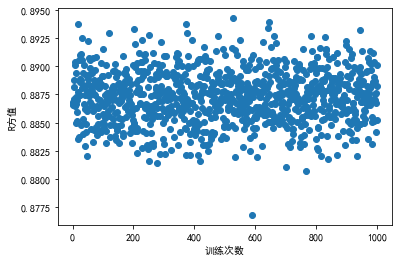

0.8943131289399053


In [305]:
x=[i for i in range(1,1001)]
plt.scatter(x,R2)
plt.xlabel("训练次数")
plt.ylabel("R方值")
plt.show()
print(max(R2))

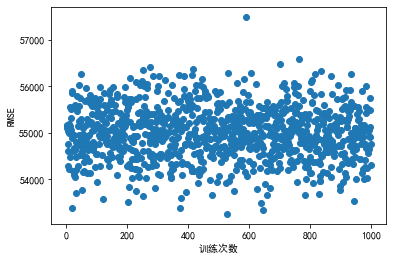

53252.6614445043


In [306]:
plt.scatter(x,RMSE)
plt.xlabel("训练次数")
plt.ylabel("RMSE")
plt.show()
print(min(RMSE))

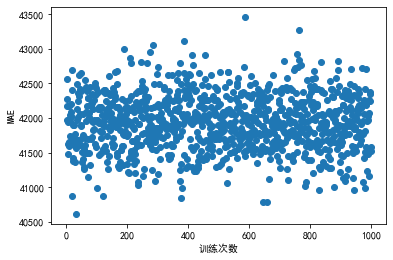

40607.96811511493


In [307]:
plt.scatter(x,MAE)
plt.xlabel("训练次数")
plt.ylabel("MAE")
plt.show()
print(min(MAE))

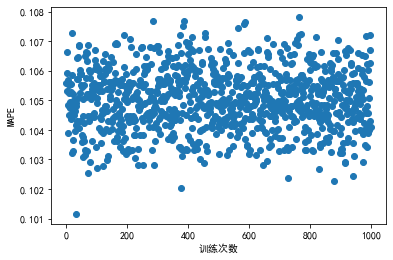

0.10114563850614391


In [308]:
plt.scatter(x,MAPE)
plt.xlabel("训练次数")
plt.ylabel("MAPE")
plt.show()
print(min(MAPE))